In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.preprocessing import Imputer
from scipy.stats import skew, norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from itertools import repeat
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from matplotlib_venn import venn2, venn3
from sklearn.preprocessing import LabelEncoder

In [2]:
df_train = pd.read_csv('input/prepared_data/train_proc.csv',  
                       parse_dates = ['Дата'])
df_test_before = pd.read_csv('input/prepared_data/test_before_proc.csv',
                             parse_dates = ['Дата'])
df_test_after = pd.read_csv('input/prepared_data/test_after_proc.csv',
                             parse_dates = ['Дата'])

In [3]:
df_train.columns

Index(['Скважина', 'Дата', 'Характер работы', 'Состояние', 'Время работы, ч',
       'Нефть, т', 'Вода, т', 'Жидкость, т', 'Попутный газ, м3', 'Закачка, м3',
       'Природный газ, м3', 'Газ из газовой шапки, м3', 'Конденсат, т',
       'Простой, ч', 'Причина простоя', 'Обводненность (масса), %',
       'Агент закачки', 'Нефть, м3', 'Жидкость, м3',
       'Добыча растворенного газа, м3', 'Тип скважины',
       'Диаметр экспл.колонны', 'Диаметр НКТ', 'Диаметр штуцера',
       'Глубина верхних дыр перфорации', 'Удлинение', 'Способ эксплуатации',
       'Тип насоса', 'Производительность ЭЦН', 'Напор', 'Частота',
       'Коэффициент сепарации', 'Глубина спуска', 'Буферное давление',
       'Давление в линии', 'Пластовое давление', 'Динамическая высота',
       'Затрубное давление', 'Давление на приеме', 'Забойное давление',
       'Дебит нефти', 'Дебит жидкости', 'Обводненность',
       'Состояние на конец месяца', 'Давление наcыщения', 'Газовый фактор',
       'Вязкость нефти в пластовых 

In [4]:
print('shape of train {}'.format(df_train.shape))
print('shape of test before {}'.format(df_test_before.shape))
print('shape of test after {}'.format(df_test_after.shape))

shape of train (15040, 86)
shape of test before (4156, 86)
shape of test after (240, 5)


### Missing data

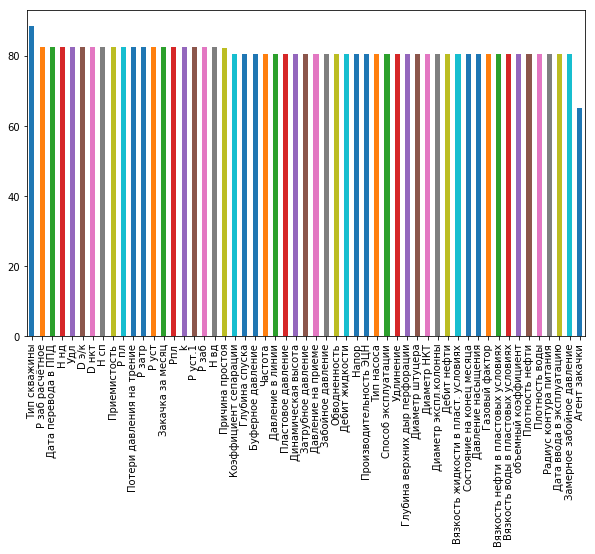

In [5]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (100*df_train.isnull().sum()/df_train.shape[0]).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
fig = plt.figure(figsize=(10,6))
missing_data.loc[missing_data['Percent']>50, 'Percent'].plot.bar()

### В этот раз координаты есть для всех скважин

In [20]:
missing_data.loc[missing_data['Percent'] == 0]

,Total,Percent
"Вода, т",0,0.0
"Попутный газ, м3",0,0.0
"Жидкость, т",0,0.0
Дата,0,0.0
Характер работы,0,0.0
"Нефть, т",0,0.0
"Время работы, ч",0,0.0
"Природный газ, м3",0,0.0
"Закачка, м3",0,0.0
group,0,0.0


#### Массив test_after - по сути данные по закачке за период когда надо сделать предсказание, т.е. на самом деле продолжение test_before но только для фичи "Закачка, м3"

In [21]:
df_test_after.head()

,Скважина,Дата,Характер работы,"Закачка, м3",group
0,b68bd6ef5017d242,2017-01-01,НАГ,1.0,36
1,b68bd6ef5017d242,2017-02-01,НАГ,134.0,36
2,b68bd6ef5017d242,2017-03-01,НАГ,461.0,36
3,b68bd6ef5017d242,2017-04-01,НАГ,423.0,36
4,b68bd6ef5017d242,2017-05-01,НАГ,446.0,36


### Группы в трейне и в тесте не пересекаются

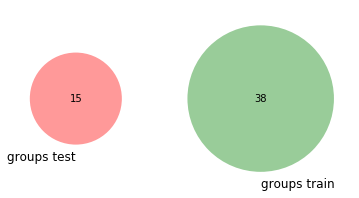

In [24]:
groups_test = df_test_before['group'].unique().tolist()
groups_train = df_train['group'].unique().tolist()
venn2(subsets = [set(groups_test), set(groups_train)],
     set_labels = ['groups test', 'groups train'])

In [27]:
lbl1 = LabelEncoder()
lbl1.fit(df_train['Характер работы'].values)
df_train['type'] = lbl1.transform(df_train['Характер работы'].values)
df_test_before['type'] = lbl1.transform(df_test_before['Характер работы'].values)

In [28]:
df_test_b_ind = df_test_before.set_index(['group', 'Скважина', 'Дата'], drop=False)
df_test_a_ind = df_test_after.set_index(['group', 'Скважина', 'Дата'], drop=False)
df_train_ind = df_train.set_index(['group', 'Скважина', 'Дата'], drop=False)

### В каждой группе 3-6 добываюших скважин и как правило 1-2 нагнетательные
Ниже карты взаимного расположения скважин из одной группы из тест и трейн сета

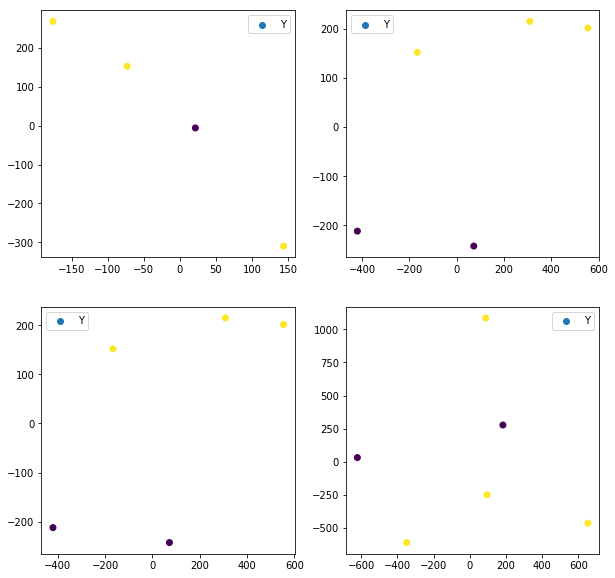

In [45]:
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
#plt.scatter(df_train.drop_duplicates('Скважина', 'first')['X'], 
#            df_train.drop_duplicates('Скважина', 'first')['Y'], 
#            c = df_train.drop_duplicates('Скважина', 'first')['gr'], label='train')
for i in range(2):
    for j in range(2):
        gr = groups_train[i+j]
        ax[i,j].scatter(df_train_ind.loc[gr].drop_duplicates('Скважина', 'first')['X'], 
            df_train_ind.loc[gr].drop_duplicates('Скважина', 'first')['Y'], 
            c = df_train_ind.loc[gr].drop_duplicates('Скважина', 'last')['type'],
            )
        ax[i,j].legend()

Text(0.5,1,'Количество скважин ДОБ/НАГ для трейн сета')

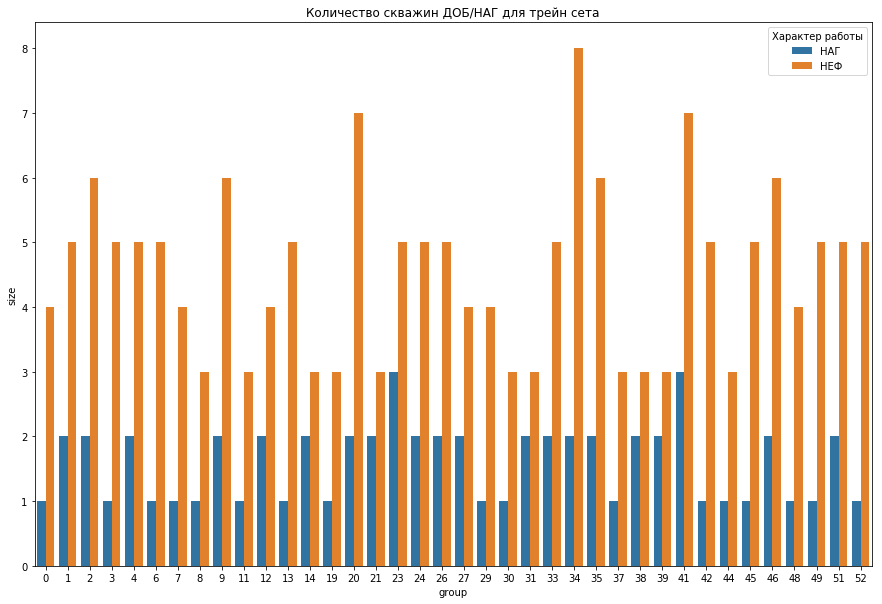

In [35]:
fig = plt.figure(figsize=(15,10))
df_type_size = df_train.drop_duplicates(subset=['Скважина', 'Характер работы']).groupby(['group', 'Характер работы']).size().rename('size').reset_index()
sns.barplot(data = df_type_size, x = 'group', y = 'size', hue = 'Характер работы');
plt.title('Количество скважин ДОБ/НАГ для трейн сета');

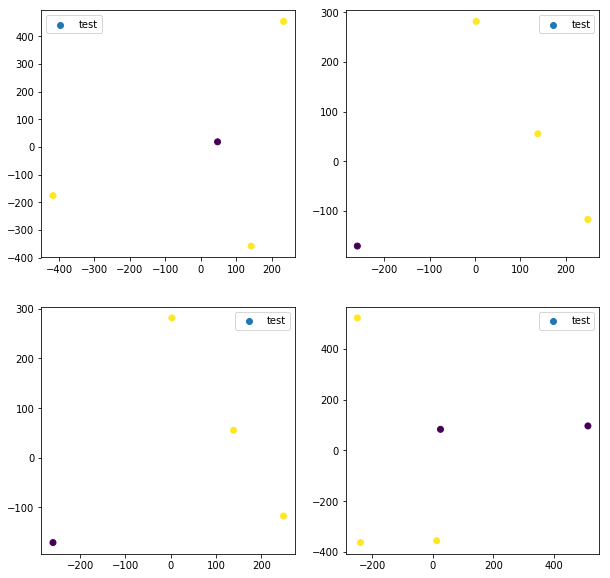

In [41]:
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
#plt.scatter(df_train.drop_duplicates('Скважина', 'first')['X'], 
#            df_train.drop_duplicates('Скважина', 'first')['Y'], 
#            c = df_train.drop_duplicates('Скважина', 'first')['gr'], label='train')
for i in range(2):
    for j in range(2):
        gr = groups_test[i+j]
        ax[i,j].scatter(df_test_b_ind.loc[gr].drop_duplicates('Скважина', 'first')['X'], 
            df_test_b_ind.loc[gr].drop_duplicates('Скважина', 'first')['Y'], 
            c = df_test_b_ind.loc[gr].drop_duplicates('Скважина', 'last')['type'],
            label='test')
        ax[i,j].legend()

Text(0.5,1,'Количество скважин ДОБ/НАГ для тест сета')

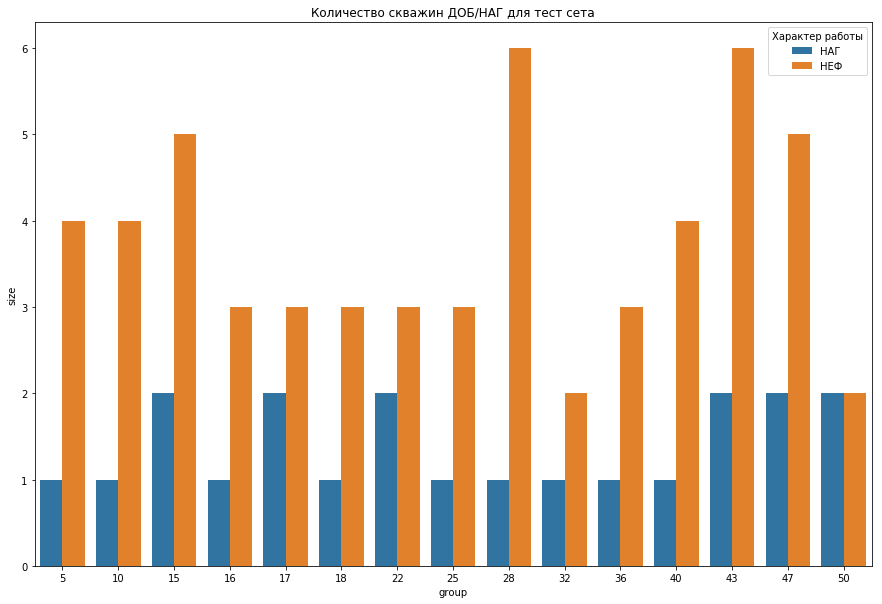

In [36]:
fig = plt.figure(figsize=(15,10))
df_test_type_size = df_test_before.drop_duplicates(subset=['Скважина', 'Характер работы']).groupby(['group', 'Характер работы']).size().rename('size').reset_index()
sns.barplot(data = df_test_type_size, x = 'group', y = 'size', hue = 'Характер работы');
plt.title('Количество скважин ДОБ/НАГ для тест сета');

In [46]:
test_before_pr_w = df_test_before.loc[df_test_before['Характер работы'] == 'НЕФ', 'Скважина'].unique().tolist()
test_before_inj_w = df_test_before.loc[df_test_before['Характер работы'] == 'НАГ', 'Скважина'].unique().tolist()
test_after_w = df_test_after['Скважина'].unique().tolist()
train_w = df_train['Скважина'].unique().tolist()

C:\Users\k.gopa\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib_venn\_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


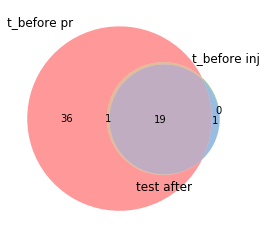

In [47]:
venn3(subsets = [set(test_before_pr_w), set(test_before_inj_w), set(test_after_w)],
     set_labels = ['t_before pr', 't_before inj', 'test after'])

In [48]:
idx = pd.IndexSlice

In [51]:
def plot_group_test(group):
    wells = df_test_b_ind.loc[group].index.get_level_values(0).unique()
    fig, ax = plt.subplots(nrows=len(wells), ncols=1, figsize=(10, len(wells)*6), sharex=True) 
    for j, well in enumerate(wells):
        df_test_b_ind.loc[idx[group, well, :]].plot(x= 'Дата', y= ['Жидкость, м3', 'Нефть, м3', 'Закачка, м3'], ax=ax[j]);
        if any(df_test_b_ind.loc[idx[group, well, :], 'Характер работы'].isin(['НАГ'])):
            df_test_a_ind.loc[idx[group, well, :]].plot(x='Дата', y =['Закачка, м3'], ax=ax[j]);
            
def plot_group_train(group):
    wells = df_train_ind.loc[group].index.get_level_values(0).unique()
    fig, ax = plt.subplots(nrows=len(wells), ncols=1, figsize=(10, len(wells)*6), sharex=True) 
    for j, well in enumerate(wells):
        df_train_ind.loc[idx[group, well, :]].plot(x= 'Дата', y= ['Жидкость, м3', 'Нефть, м3', 'Закачка, м3'], ax=ax[j]);
        #if any(df_test_b_ind.loc[idx[group, well, :], 'Характер работы'].isin(['НАГ'])):
         #   df_test_a_ind.loc[idx[group, well, :]].plot(x='Дата', y =['Закачка, м3'], ax=ax[j]);

### Пример как выглядит объединенные ряды test_before и test_after
Тест:

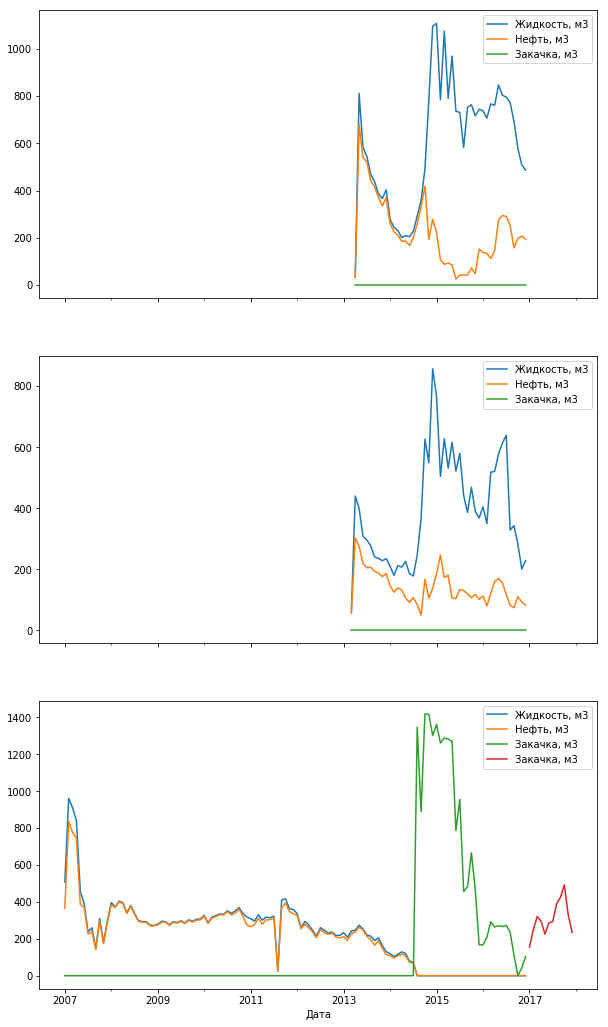

In [53]:
plot_group_test(groups_test[3])

Трейн:

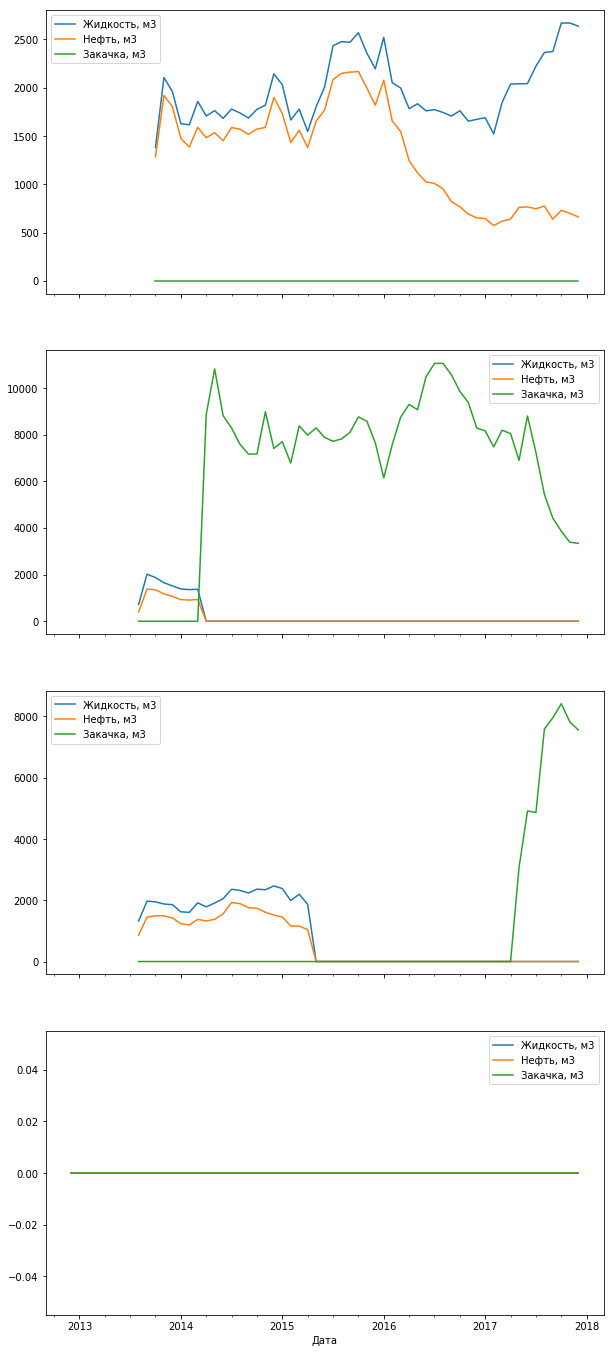

In [54]:
plot_group_train(groups_train[10])